# Example 1 : Time series SRA

Time series analysis to compute surface response spectrum and site 
amplification functions.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [4]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Load time series data

In [5]:
fname = 'data/NIS090.AT2'
with open(fname) as fp:
    next(fp)
    description = next(fp).strip()
    next(fp)
    parts = next(fp).split()
    time_step = float(parts[1])

    accels = [float(p) for l in fp for p in l.split()]

    ts = pysra.motion.TimeSeriesMotion(
        fname, description, time_step, accels)

In [6]:
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05])

There are a few supported file formats. AT2 files can be loaded as follows:

In [7]:
ts = pysra.motion.TimeSeriesMotion.load_at2_file(fname)
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05])

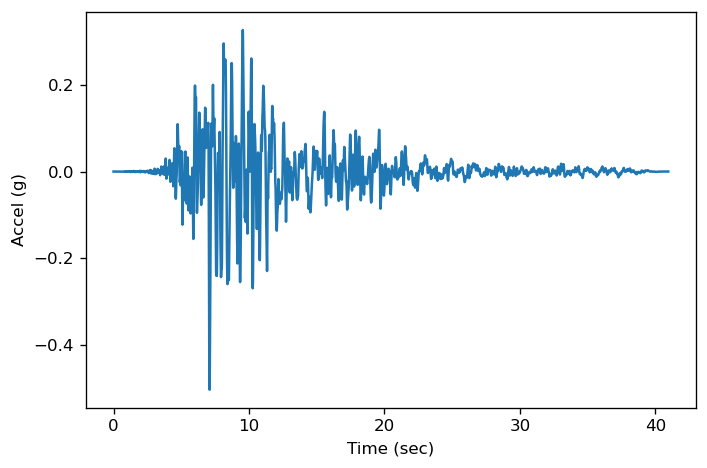

In [8]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='Time (sec)', ylabel='Accel (g)')
fig.tight_layout();

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [9]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.SoilType(
            'Soil', 18., None, 0.05
        ),
        30, 400
    ),
    pysra.site.Layer(
        pysra.site.SoilType(
            'Rock', 24., None, 0.01
        ),
        0, 1200
    ),
])

## Create the site response calculator

In [10]:
calc = pysra.propagation.LinearElasticCalculator()

## Specify the output

In [12]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.FourierAmplitudeSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Bandwidth for Konno-Omachi smoothing window
        ko_bandwidth=30),
    pysra.output.StrainTSOutput(
        pysra.output.OutputLocation('within', depth=10),
    )
])

## Perform the calculation

Compute the response of the site, and store the state within the calculation object. Nothing is provided.

In [13]:
calc(ts, profile, profile.location('outcrop', index=-1))

Calculate all of the outputs from the calculation object.

In [14]:
outputs(calc)

## Plot the outputs

Create a few plots of the output.

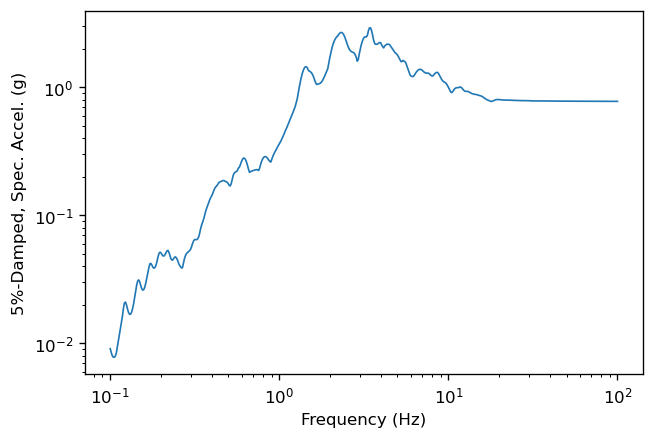

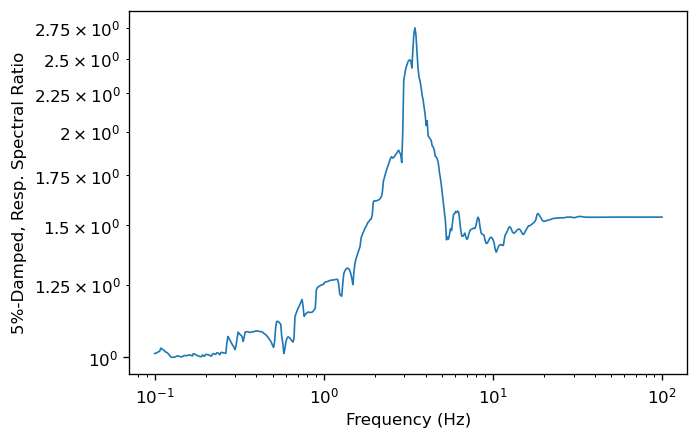

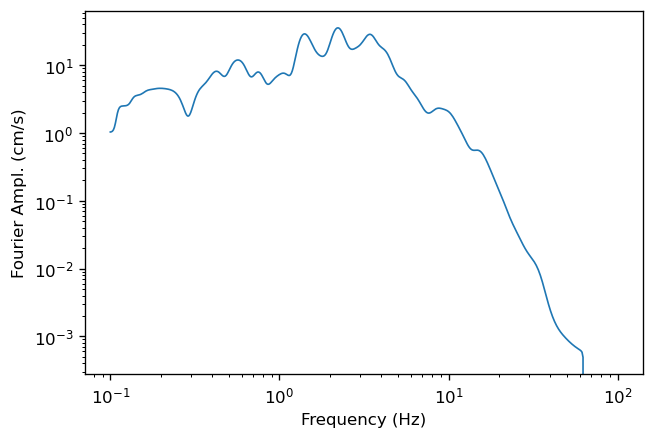

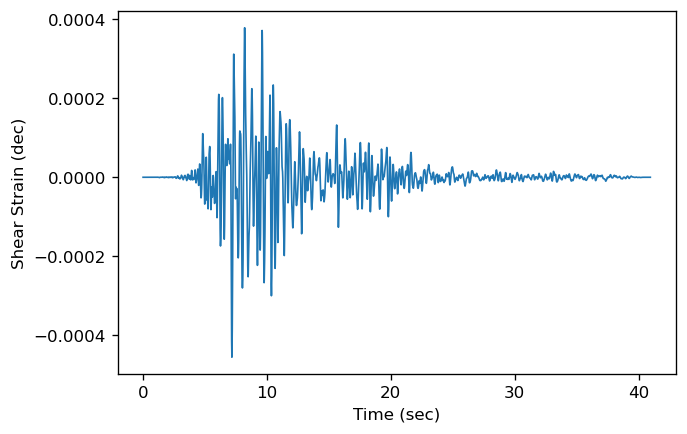

In [16]:
for o in outputs:
    o.plot(style='indiv')

In [33]:
import pandas as pd

In [34]:
s = pd.Series(100 * outputs[-1].values, index=outputs[-1].refs)
s

0.00     0.000003
0.01     0.000003
0.02     0.000003
0.03     0.000003
0.04     0.000003
           ...   
40.91    0.000004
40.92    0.000004
40.93    0.000004
40.94    0.000004
40.95    0.000003
Length: 4096, dtype: float64

In [36]:
s.to_clipboard(header=False)